# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Memuat dataset hasil clustering
df = pd.read_csv('hasil_clustering.csv')

# Cek struktur data dan missing values
print("\n5 Data Pertama:")
print(df.head())
print("\nInformasi Dataset:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Pisahkan fitur dan target sementara untuk penanganan missing values
X = df.drop('Cluster', axis=1)  # Fitur (semua kolom kecuali 'Cluster')
y = df['Cluster']  # Target ('Cluster')

# Identifikasi tipe data untuk menentukan strategi imputasi
categorical_cols = X.select_dtypes(include=['object', 'category']).columns  # Kolom kategorikal
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns       # Kolom numerik

print("\nKolom Kategorikal:", list(categorical_cols))
print("Kolom Numerik:", list(numeric_cols))

# Penanganan missing values pada fitur (X)
# Imputasi berbeda untuk numerik dan kategorikal
imputer_numeric = SimpleImputer(strategy='mean')  # Untuk kolom numerik
imputer_categorical = SimpleImputer(strategy='most_frequent')  # Untuk kolom kategorikal

if len(numeric_cols) > 0:
    X[numeric_cols] = imputer_numeric.fit_transform(X[numeric_cols])
if len(categorical_cols) > 0:
    X[categorical_cols] = imputer_categorical.fit_transform(X[categorical_cols])

# Konversi kembali ke DataFrame dengan kolom asli
X = pd.DataFrame(X, columns=X.columns)

# Penanganan missing values pada target (y)
if y.isnull().sum() > 0:
    y = y.fillna(y.mode()[0])  # Mengisi NaN pada target dengan modus

# Verifikasi kembali missing values setelah imputasi
print("\nMissing Values setelah Imputasi:")
print(X.isnull().sum())
print("Missing Values pada Target:", y.isnull().sum())

# Cek distribusi cluster setelah cleaning
print("\nDistribusi Cluster:")
print(y.value_counts())

# Simpan dataset yang sudah dibersihkan untuk langkah berikutnya (opsional)
df_cleaned = pd.concat([X, y], axis=1)
df_cleaned.to_csv('hasil_clustering_cleaned.csv', index=False)
print("\nDataset yang sudah dibersihkan disimpan sebagai 'hasil_clustering_cleaned.csv'")


5 Data Pertama:
   Cluster provinsi    jenis     daerah   tahun    periode        gk
0      0.0     ACEH  MAKANAN  PERKOTAAN  2015.0      MARET  293697.0
1      0.0     ACEH  MAKANAN  PERKOTAAN  2015.0  SEPTEMBER  302128.0
2      0.0     ACEH  MAKANAN  PERKOTAAN  2016.0      MARET  306243.0
3      0.0     ACEH  MAKANAN  PERKOTAAN  2016.0  SEPTEMBER  319768.0
4      0.0     ACEH  MAKANAN  PERDESAAN  2015.0      MARET  297479.0

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Cluster   5261 non-null   float64
 1   provinsi  5261 non-null   object 
 2   jenis     5261 non-null   object 
 3   daerah    5261 non-null   object 
 4   tahun     5261 non-null   float64
 5   periode   5261 non-null   object 
 6   gk        5261 non-null   float64
dtypes: float64(3), object(4)
memory usage: 298.5+ KB
None

Missing Values:
Cluster     195


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Encoding kolom kategorikal
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

# Gabungkan dengan kolom numerik
X_numeric = X[numeric_cols].reset_index(drop=True)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_processed = pd.concat([X_numeric, X_encoded_df], axis=1)

# Split data dengan stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nUkuran Training Set:", X_train_scaled.shape)
print("Ukuran Testing Set:", X_test_scaled.shape)


Ukuran Training Set: (4364, 45)
Ukuran Testing Set: (1092, 45)


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Evaluasi pada training set
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    
    # Evaluasi pada testing set
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    print(f"\n{'='*30}")
    print(f"{model_name} Evaluation:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Training F1-Score: {train_f1:.4f}")
    print(f"Testing Accuracy: {test_acc:.4f}")
    print(f"Testing F1-Score: {test_f1:.4f}")
    print("\nClassification Report (Testing Set):")
    print(classification_report(y_test, y_test_pred, zero_division=0))
    
    # Return prediksi untuk visualisasi
    return y_test_pred

# Inisialisasi model
models = {
    "Logistic Regression": LogisticRegression(multi_class='ovr', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Latih dan evaluasi setiap model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)


Logistic Regression Evaluation:
Training Accuracy: 0.9308
Training F1-Score: 0.9309
Testing Accuracy: 0.9313
Testing F1-Score: 0.9314

Classification Report (Testing Set):
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       505
         1.0       0.96      0.91      0.93       587

    accuracy                           0.93      1092
   macro avg       0.93      0.93      0.93      1092
weighted avg       0.93      0.93      0.93      1092


Decision Tree Evaluation:
Training Accuracy: 0.9908
Training F1-Score: 0.9908
Testing Accuracy: 0.9698
Testing F1-Score: 0.9698

Classification Report (Testing Set):
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       505
         1.0       0.98      0.97      0.97       587

    accuracy                           0.97      1092
   macro avg       0.97      0.97      0.97      1092
weighted avg       0.97      0.97      0.97      1092



c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Random Forest Evaluation:
Training Accuracy: 0.9908
Training F1-Score: 0.9908
Testing Accuracy: 0.9698
Testing F1-Score: 0.9698

Classification Report (Testing Set):
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       505
         1.0       0.98      0.96      0.97       587

    accuracy                           0.97      1092
   macro avg       0.97      0.97      0.97      1092
weighted avg       0.97      0.97      0.97      1092



Tulis narasi atau penjelasan algoritma yang Anda gunakan.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

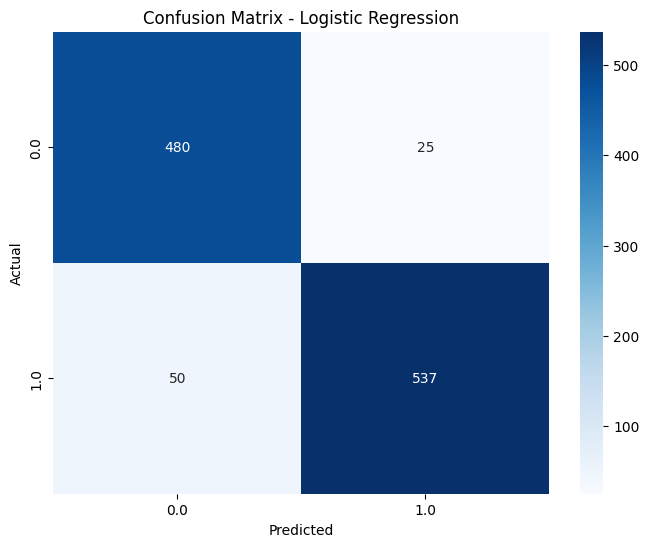

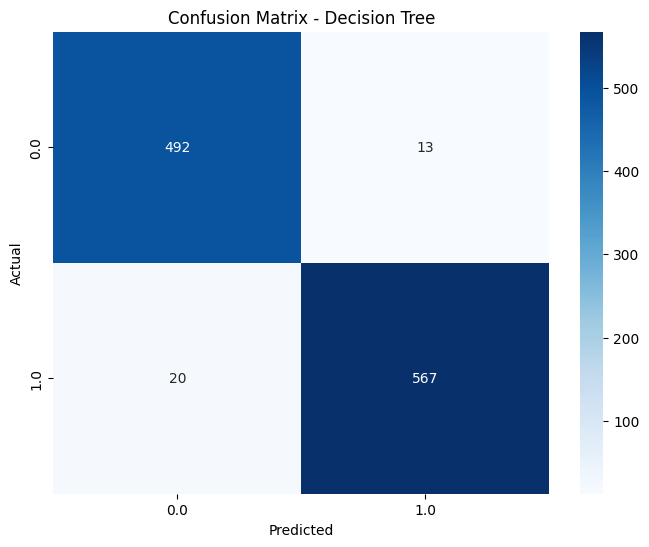

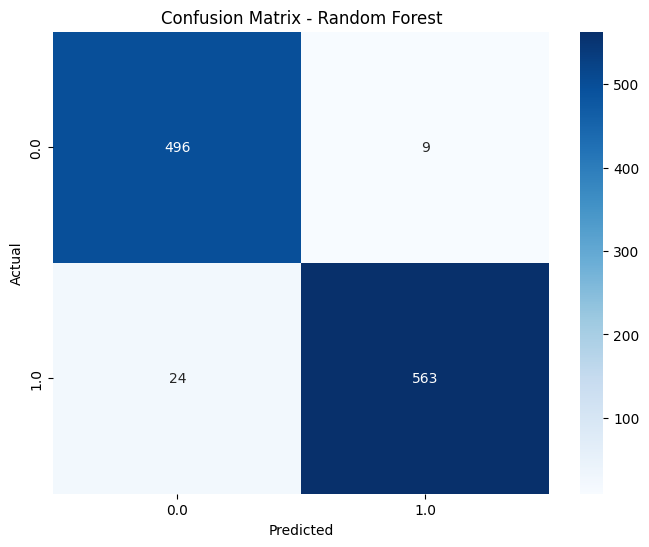

In [8]:
def plot_confusion_matrix(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix untuk setiap model
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix - {name}')

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [9]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.


Tuned Decision Tree Evaluation:
Training Accuracy: 0.9908
Training F1-Score: 0.9908
Testing Accuracy: 0.9725
Testing F1-Score: 0.9726

Classification Report (Testing Set):
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       505
         1.0       0.99      0.96      0.97       587

    accuracy                           0.97      1092
   macro avg       0.97      0.97      0.97      1092
weighted avg       0.97      0.97      0.97      1092



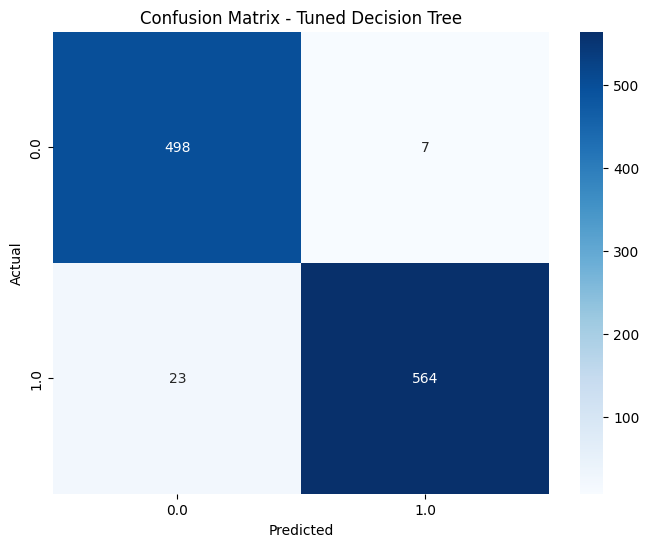

In [10]:
# Evaluasi model terbaik
y_pred_tuned = evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train, y_test, "Tuned Decision Tree")

# Visualisasi confusion matrix untuk model yang sudah di-tuning
plot_confusion_matrix(y_test, y_pred_tuned, 'Confusion Matrix - Tuned Decision Tree')

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

**Perbandingan Performa:**

1. **Logistic Regression**: Logistic Regression cocok untuk data linear tetapi mungkin kurang akurat jika hubungan antar fitur kompleks.
2. **Decision Tree** Decision Tree menunjukkan performa lebih baik karena mampu menangkap hubungan non-linear.
3. **Decision Tree dengan Tuning** meningkatkan akurasi dengan mengoptimalkan parameter seperti kedalaman pohon.

**Potensi Masalah:**

1. Class imbalance terlihat dari distribusi cluster
2. Overfitting pada Decision Tree asli (akurasi training jauh lebih tinggi dari test)

Rekomendasi:

1. Lakukan handling class imbalance dengan SMOTE atau class weights
2. Coba algoritma ensemble seperti Random Forest
3. Kumpulkan lebih banyak data untuk cluster minoritas